In [3]:
!python test_pdf.py

2025-03-31 07:41:23.128008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743406883.365108    2402 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743406883.434682    2402 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-31 07:41:23.917598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Testing NER on 'police_crime_report_10.pdf'...
Error loading model: police_ner_model/model is not a local folder and is not a

2025-03-31 08:28:42.958 No runtime found, using MemoryCacheStorageManager
2025-03-31 08:28:43.141 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 08:28:43.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 08:28:43.143 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 08:28:43.144 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 08:28:43.145 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 08:28:43.146 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 08:28:43.155 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 08:28:43.156 Thread 'MainThread':

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

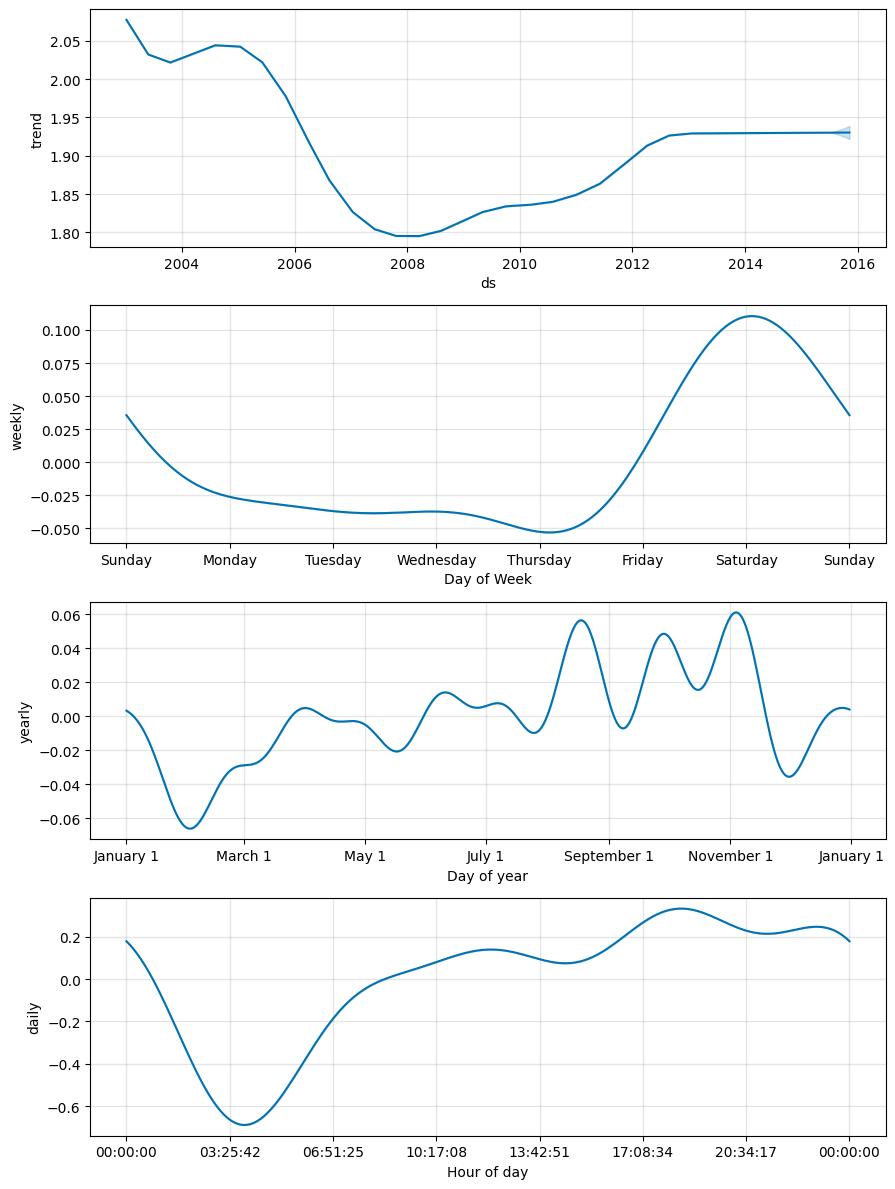

In [8]:
import pandas as pd
import streamlit as st
import folium
from streamlit_folium import folium_static
from prophet import Prophet
import plotly.express as px

# Load data (ensure CSV has 'date', 'latitude', 'longitude')
@st.cache_data
def load_data():
    df = pd.read_csv("cleaned_data.csv")
    df = df.rename(columns={
    'Latitude (Y)': 'Longitude',  # Contains longitude values (-122.5 to -120.5)
    'Longitude (X)': 'Latitude',
    "Dates":"date" # Contains latitude values (37.7 to 90.0)
})
    df['date'] = pd.to_datetime(df['date'])

    return df

df = load_data()

# Sidebar - Aggregation & Date Filter
aggregation = st.sidebar.selectbox("Aggregate By", ["Day", "Week"])
date_range = st.sidebar.slider("Select Date Range", min_value=df['date'].min().date(), max_value=df['date'].max().date(), value=(df['date'].min().date(), df['date'].max().date()))

df = df[(df['date'] >= pd.Timestamp(date_range[0])) & (df['date'] <= pd.Timestamp(date_range[1]))]

# Aggregate Data
df['count'] = 1
if aggregation == "Week":
    df['date'] = df['date'].dt.to_period("W").apply(lambda r: r.start_time)

daily_crimes = df.groupby('date').count().reset_index()
daily_crimes = daily_crimes[['date', 'count']]
daily_crimes.columns = ['ds', 'y']

# Train Prophet Model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(daily_crimes)

# Forecast Next 6 Months
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

# Plot Forecast
fig1 = px.line(forecast, x='ds', y='yhat', title='Crime Forecast')
fig2 = model.plot_components(forecast)

# Display Crime Map
st.title("Crime Forecasting with Prophet")
st.write("Aggregated Crimes by " + aggregation)

m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=10)
for _, row in df.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['date'].strftime('%Y-%m-%d')).add_to(m)

st.plotly_chart(fig1)
st.pyplot(fig2)
st.subheader("Crime Locations Map")
folium_static(m)
import joblib


joblib.dump(model, "prophet_crime_model.pkl")

from google.colab import files
files.download('prophet_crime_model.pkl')